In [40]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import os
import shutil
import glob
import re

import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [64]:
logs = ['/Users/nathaning/Dropbox/projects/semantic_pca/log_performance/log/xval_set_0_1024/segnet/caffe.nathan-workstation.nathan.log.INFO.20170717-145337.32376',
        '/Users/nathaning/Dropbox/projects/semantic_pca/log_performance/log/xval_set_0_1024/segnet_basic/caffe.nathan-workstation.nathan.log.INFO.20170712-174628.11962']
colors = ['k', 'b']
names = ['SegNet', 'SegNet-Basic']
batch_sizes = [6, 16]
legend_names = ['Train Loss', 'Test Accuracy']

LOG: /Users/nathaning/Dropbox/projects/semantic_pca/log_performance/log/xval_set_0_1024/segnet/caffe.nathan-workstation.nathan.log.INFO.20170717-145337.32376
Found 150 entries for train iter
Found 150 entries for train loss
Found 16 entries for test iter
Found 16 entries for test acc
Plotting raw values

LOG: /Users/nathaning/Dropbox/projects/semantic_pca/log_performance/log/xval_set_0_1024/segnet_basic/caffe.nathan-workstation.nathan.log.INFO.20170712-174628.11962
Found 1307 entries for train iter
Found 1307 entries for train loss
Found 66 entries for test iter
Found 66 entries for test acc
Plotting raw values



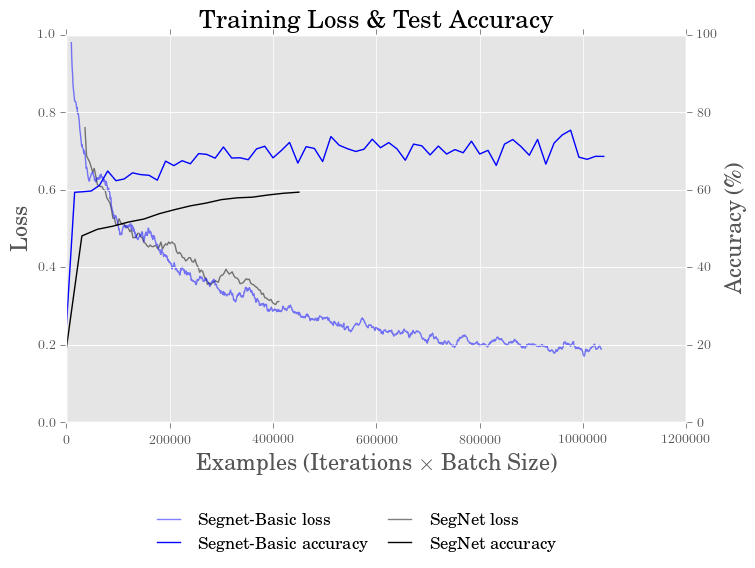

In [91]:
def moving_average(a, n=25) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# Set up plot:
plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(8,5))
# ax1.set_facecolor('white')
ax2 = ax1.twinx()
ax1.set_xlabel(r'Examples (Iterations $\times$ Batch Size)', size=16)
ax1.set_ylabel(r'Loss', size=16)
ax2.set_ylabel(r'Accuracy (\%)', size=16)
ax1.set_ylim([0,1])
ax2.set_ylim([0,100])
loss_pattern = r"Iteration (?P<iter_num>\d+),.+loss = (?P<loss_val>[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?)"
train_iter_pattern = r"Iteration (?P<iter_num>\d+), lr ="
train_loss_pattern = r"Train net output #1: loss = (?P<accuracy>[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?)"
test_pattern = [r"Iteration (?P<iter_num>\d+), Testing net",
                r"Test net output #0: accuracy = (?P<accuracy>[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?)",]
#                 r"Test net output #1: loss = (?P<accuracy>[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?)"]
handles = []


for logfile, color, name, batchsize in zip(logs, colors, names, batch_sizes):
    print 'LOG: {}'.format(logfile)
    with open(logfile, 'r') as f:
        log = f.read()

    train_iter = []
    train_loss = []

    for r in re.findall(train_iter_pattern, log):
        train_iter.append(float(r))
    print 'Found {} entries for train iter'.format(len(train_iter))

    for r in re.findall(train_loss_pattern, log):
        train_loss.append(float(r[0]))
    print 'Found {} entries for train loss'.format(len(train_loss))

    # Test patterns
    test_iter = []
    for r in re.findall(test_pattern[0], log):
        test_iter.append(r)
    print 'Found {} entries for test iter'.format(len(test_iter))

    test_acc = []
    for r in re.findall(test_pattern[1], log):
        test_acc.append(float(r[0]) * 100.)
    print 'Found {} entries for test acc'.format(len(test_acc))
    
#     test_loss = []
#     for r in re.findall(test_pattern[2], log):
#         test_loss.append(float(r[0]) * 100.)
#     print 'Found {} entries for test loss'.format(len(test_loss))
#     print test_loss

    train_iter = np.asarray(train_iter, dtype=np.float) * batchsize
    train_loss = np.asarray(train_loss, dtype=np.float)
    test_iter = np.asarray(test_iter, dtype=np.float) * batchsize
    test_acc = np.asarray(test_acc, dtype=np.float)
#     test_loss = np.asarray(test_loss, dtype=np.float)
#     test_loss /= test_loss.max()

    if moving_average:
        train_iter = moving_average(train_iter)
        train_loss = moving_average(train_loss)
        test_iter = moving_average(test_iter, n=1)
        test_acc = moving_average(test_acc, n=1)
#         test_loss = moving_average(test_loss, n=1)


    print "Plotting raw values"
    ax1.plot(train_iter, train_loss, color = color, linestyle = '-', alpha=0.5)
#     ax1.plot(test_iter, test_loss, color = color, linestyle = '-.')
    ax2.plot(test_iter, test_acc, color = color) 

    if log_scale:
        print "Plotting iterations in Log scale"
        ax1.set_xscale('log')

    handles += [mlines.Line2D([], [], color=color, label=name+' loss', linestyle = '-', alpha=0.5),
#                 mlines.Line2D([], [], color=color, label=name+' test loss', linestyle = '-.'),
               mlines.Line2D([], [], color=color, label=name+' accuracy'),]
    print ''

lgd = plt.legend(loc=8,
           bbox_to_anchor=(0.5, -0.35),
           ncol=len(names), mode="expand", borderaxespad=0.,
           handles=handles)

plt.title('Training Loss \& Test Accuracy', size=18)
fig.savefig('/Users/nathaning/Dropbox/_Papers/pca segmentation/Figs/loss_plots/plots.pdf',
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
